In [1]:
from Bio import SeqIO, Seq
from Bio.Seq import CodonTable
from Bio.Seq import Seq
from Bio.Data.CodonTable import TranslationError
import pandas as pd
import numpy as np
from itertools import combinations, product, izip
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

In [2]:
all_muts = {l.split('\t')[0]: float(l.split('\t')[1]) for l in open('../titer_model/titered_output/antigenic_mutations.tsv')}
antigenic_mutations = {k:v for k,v in all_muts.items() if len(k.split(','))==1}
antigenic_clusters = {tuple(k.split(',')) : v for k,v in all_muts.items() if len(k.split(',')) > 1}

In [3]:
# print len(antigenic_mutations.keys())+len(antigenic_clusters.keys())
# print len(json.load(open('../titer_model/titered_output/titered_substitution_model.json', 'r'))['mutations'].keys())

In [4]:
seqs = {s.name : s for s in SeqIO.parse(open('../data/sequences/titered_strains_alignment.mfa', 'r'), 'fasta')}
aa_aln = {k: Seq.translate(Seq(str(v.seq).replace('-', 'N'))) for k,v in seqs.items()}

In [5]:
def get_mutations(seq1, seq2):
    '''
    loops over all translations (listed in self.proteins) and returns a list of
    between as tuples (protein, mutation) e.g. (HA1, 159F)
    '''
    muts = ['E:'+aa1+str(pos+1)+aa2 for pos, (aa1, aa2)
                in enumerate(izip(seq1, seq2)) if aa1!=aa2]
    return muts

def get_antigenic_mutations(seq1, seq2, antigenic_mutations, antigenic_clusters):
    
    observed_antigenic_mutations = []
    observed_mutations = get_mutations(seq1, seq2)
    
    for m in antigenic_mutations.keys():
        if m in observed_mutations:
            observed_antigenic_mutations.append(m)
            
    for cl in antigenic_clusters.keys():
        if any([m in observed_mutations for m in cl]):
            observed_antigenic_mutations.append(cl)
    
    return observed_antigenic_mutations

def annotate_mutation(mut, antigenic_mutations, antigenic_clusters):
    
    if type(mut) == tuple:
        size = len(mut)
        db = antigenic_clusters[mut]
        mut = ','.join(mut)

    else:
        size = 1
        db = antigenic_mutations[mut]
        
    return {'size': size, 'db': db, 'mut': mut}

def compare_strains(strain1, strain2, aa_aln, antigenic_mutations, antigenic_clusters):
    
    serotype1 = strain1.split('/')[0]
    serotype2 = strain2.split('/')[0]
    
    seq1 = aa_aln[strain1]
    seq2 = aa_aln[strain2]
    
    observed_antigenic_mutations = get_antigenic_mutations(seq1, seq2, antigenic_mutations, antigenic_clusters)
    observed_antigenic_mutations = [annotate_mutation(mut, antigenic_mutations, antigenic_clusters) for mut in observed_antigenic_mutations]
    for mut in observed_antigenic_mutations:
        mut.update({'serotype1': serotype1, 'serotype2': serotype2})
    return observed_antigenic_mutations

all_observed_antigenic_mutations = []
for strain1, strain2 in combinations(aa_aln.keys(),2):
    all_observed_antigenic_mutations += compare_strains(strain1, strain2, aa_aln, antigenic_mutations, antigenic_clusters)

In [6]:
antigenic_df = pd.DataFrame(all_observed_antigenic_mutations)

categories = []
for (s1,s2) in zip(antigenic_df['serotype1'], antigenic_df['serotype2']):
    if s1 == s2:
        categories.append(s1)
    else:
        categories.append('Interserotype')
        
antigenic_df['category'] = categories
antigenic_df = antigenic_df.drop(['serotype1', 'serotype2'], axis=1)
antigenic_counts = antigenic_df.groupby(['mut', 'category', 'db', 'size']).size().reset_index(name='count')

In [7]:
antigenic_counts.to_csv('./attachments/antigenic_mutation_counts.csv')

In [12]:
sns.set(style='whitegrid', font_scale=1.2)

def plot_mutations(all_counts, category, ax, x='position', y='count', c='db', 
                   s=200, alpha = 0.6, s_coeff = 1., cmap=plt.cm.viridis):
    
    counts = all_counts.loc[all_counts['category'] == category]
    
    if category != 'Interserotype':
        within_serotype = all_counts.loc[all_counts['category'] != 'Interserotype']
        ymax = within_serotype[y].max()
        vmax = within_serotype[c].max()
        vmin = within_serotype[c].min()
    else:
        between_serotypes = all_counts.loc[all_counts['category'] == 'Interserotype']
        ymax = between_serotypes[y].max()
        vmax = between_serotypes[c].max()
        vmin = between_serotypes[c].min()
    
    norm = mpl.colors.Normalize(vmax=vmax, vmin=vmin)
    
    singleton_counts = counts.loc[counts['mut'].str.count(',')==0]
    singleton_counts['position'] = singleton_counts['mut'].str[3:-1].astype(int)
    if type(s) == str:
        s_singleton = singleton_counts[s]
    else:
        s_singleton = s
        
    ax.scatter(singleton_counts[x], singleton_counts[y], s=s_singleton*s_coeff, c=singleton_counts[c], 
           norm = norm, alpha=alpha, edgecolors="grey", linewidth=2, cmap=cmap, marker='o')

    cluster_counts = counts.loc[counts['mut'].str.count(',')>0]

    for idx, cluster in cluster_counts.iterrows():
        position = [int(m[3:-1]) for m in cluster['mut'].split(',')]
        
        if type(s) == str:
            cl_s = cluster[s]
        else:
            cl_s = s
        
        if x=='position':
            cl_x=position
            cl_y= [cluster[y]]*len(cl_x)

        else:
            cl_x=cluster[x]
            cl_y = cluster[y]
            
        if s == 'size':
            marker = 'o'
        else:
            marker = 'v'
        
        ax.scatter(cl_x, cl_y, s=cl_s*s_coeff, c=cmap(norm(cluster[c])), 
                  alpha=alpha, edgecolors="darkgrey", linewidth=2, marker=marker, zorder=len(counts)+1)    
        ax.plot(cl_x, cl_y, '--', c='darkgray', zorder=len(counts)+2)
    
    if x=='position':
        ax.set_xlim(0,495)
    else:
        ax.set_xlim(all_counts[x].min()*.9, all_counts[x].max()*1.1)
        
    ax.set_ylim(0, ymax*1.1)    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(category)

serotype_colormaps = {
    'Interserotype': plt.cm.Greys,
    'DENV1': plt.cm.Blues,
    'DENV2': plt.cm.Greens,
    'DENV3': plt.cm.Purples,
    'DENV4': plt.cm.Reds
}

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


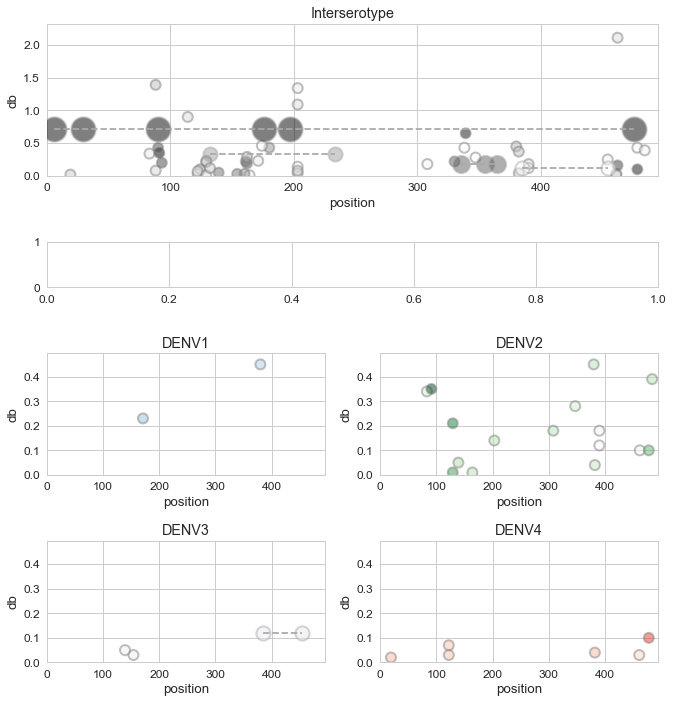

In [13]:
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[0.05,1,1], height_ratios=[1,.3,.8,.8])

X = 'position'
Y = 'db'
S = 'size'
C = 'count'
S_coeff = 100.

ax0 = plt.subplot(gs[0,1:])
plot_mutations(antigenic_counts, 'Interserotype', ax0, x=X, y=Y, 
               s=S, s_coeff = S_coeff, alpha=0.5, c=C, cmap=serotype_colormaps['Interserotype'])

ax1 = plt.subplot(gs[2,1])
plot_mutations(antigenic_counts, 'DENV1', ax1, x=X, y=Y, 
               s=S, s_coeff = S_coeff, alpha=0.5, c=C, cmap=serotype_colormaps['DENV1'])

ax2 = plt.subplot(gs[2,2])
plot_mutations(antigenic_counts, 'DENV2', ax2, x=X, y=Y, 
               s=S, s_coeff = S_coeff, alpha=0.5, c=C, cmap=serotype_colormaps['DENV2'])

ax3 = plt.subplot(gs[3,1])
plot_mutations(antigenic_counts, 'DENV3', ax3, x=X, y=Y, 
               s=S, s_coeff = S_coeff, alpha=0.5, c=C, cmap=serotype_colormaps['DENV3'])

ax4 = plt.subplot(gs[3,2])
plot_mutations(antigenic_counts, 'DENV4', ax4, x=X, y=Y, 
               s=S, s_coeff = S_coeff, alpha=0.5, c=C, cmap=serotype_colormaps['DENV4'])

gene_ax = plt.subplot(gs[1,1:])



# cbar_ax = plt.subplot(gs[:,0])
# norm = mpl.colors.Normalize(antigenic_counts[C].min(), antigenic_counts[C].max())
# cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap='viridis',
#                                 norm=norm,
#                                 orientation='vertical', 
#                                 alpha=0.5,
#                                 label=r'Antigenic effect, $d_b$'+'\n'+r'$Log_2$(normalized titers)',
#                                 ticklocation='left')

plt.tight_layout()
plt.show()